# DATA PREPROCESSING

In [ ]:
import pandas as pd
import nltk
import ast
nltk.download('punkt')
nltk.download('punkt_tab')

df = pd.read_csv(r'/content/Dataset_B_POS_test.csv')

df['POS'] = df['POS'].apply(ast.literal_eval)



df['tokens'] = df['Sentence'].apply(nltk.word_tokenize)


mismatched_rows = []

for i, (tokens, tags) in enumerate(zip(df['tokens'], df['POS'])):
    if len(tokens) != len(tags):
        mismatched_rows.append(i)

new_df = df.drop(mismatched_rows).reset_index(drop=False)

In [ ]:
assert all(len(tokens) == len(tags) for tokens, tags in zip(new_df['tokens'], new_df['POS']))

In [ ]:
with open('preprocessed_dataset_test.txt', 'w') as f:
    for tokens, tags in zip(new_df['tokens'], new_df['POS']):
      for token, tag in zip(tokens, tags):
        f.write(f"{token}\t{tag}\n")
      f.write("\n")

# EXPLOATAORY DATA ANALYSIS (EDA)

In [ ]:
pip install wordcloud

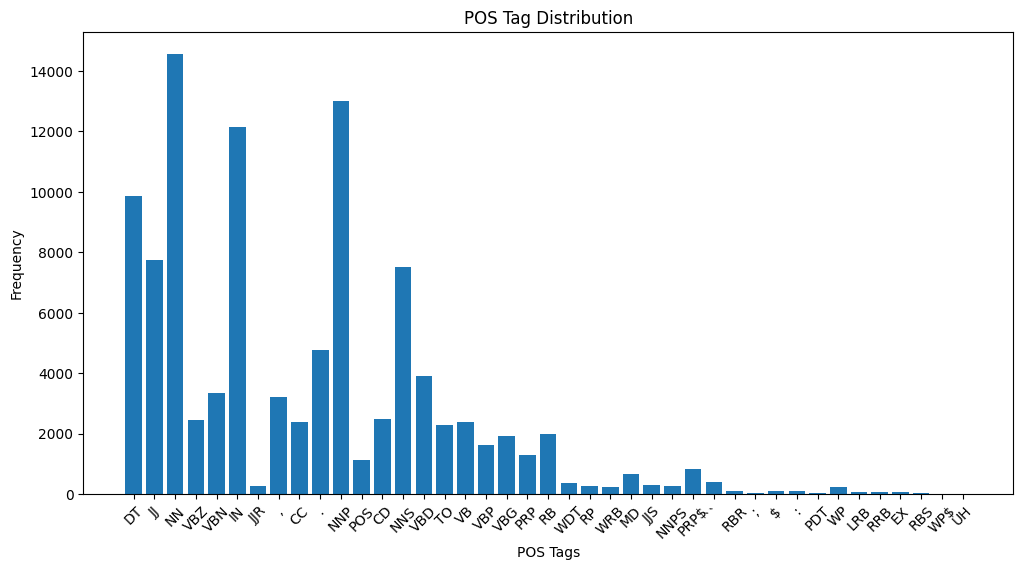

In [ ]:

from collections import Counter
import matplotlib.pyplot as plt

all_tags = [tag for tags in new_df['POS'] for tag in tags]
tag_counts = Counter(all_tags)

plt.figure(figsize=(12, 6))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xticks(rotation=45)
plt.title("POS Tag Distribution")
plt.xlabel("POS Tags")
plt.ylabel("Frequency")
plt.show()


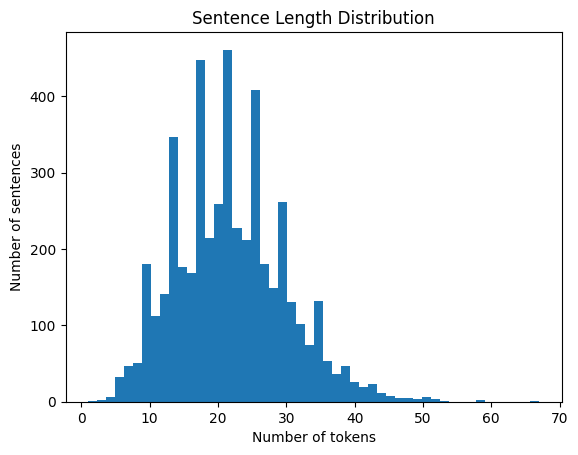

In [ ]:
sentence_lengths = new_df['tokens'].apply(len)

plt.hist(sentence_lengths, bins=50)
plt.title("Sentence Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.show()

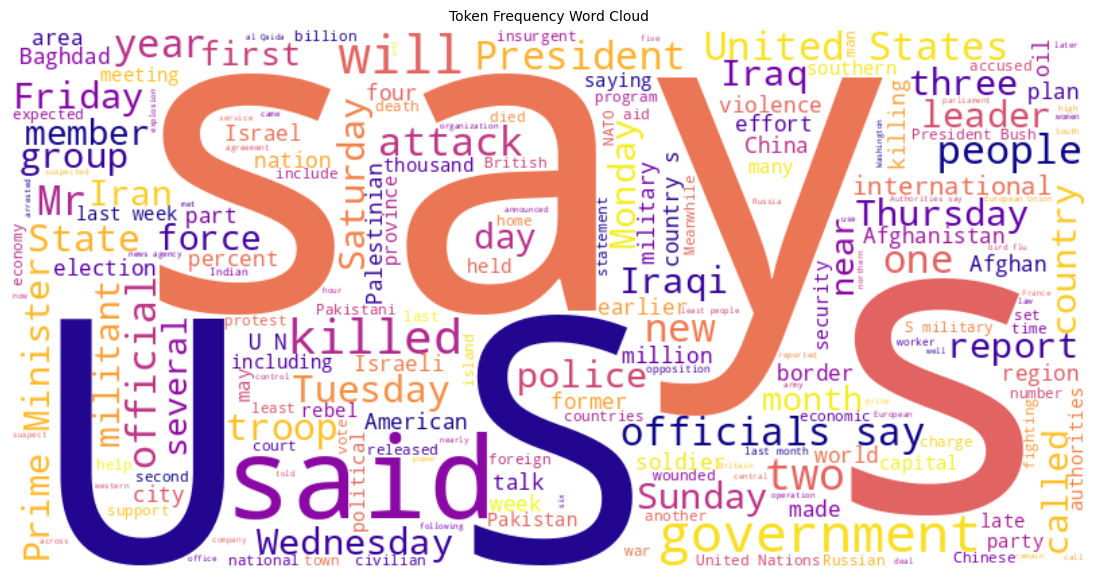

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools

all_tokens = list(itertools.chain.from_iterable(df['tokens']))

text = ' '.join(all_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Token Frequency Word Cloud", fontsize=10, )
plt.show()


# LSTM

Epoch 1/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 100s 200ms/step - accuracy: 0.2103 - loss: 2.8931 - val_accuracy: 0.5316 - val_loss: 0.7369
Epoch 2/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 143s 201ms/step - accuracy: 0.5394 - loss: 0.6752 - val_accuracy: 0.5784 - val_loss: 0.3858
Epoch 3/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 138s 193ms/step - accuracy: 0.5751 - loss: 0.3932 - val_accuracy: 0.5861 - val_loss: 0.2845
Epoch 4/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 142s 194ms/step - accuracy: 0.5852 - loss: 0.2943 - val_accuracy: 0.5899 - val_loss: 0.2338
Epoch 5/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 98s 206ms/step - accuracy: 0.5891 - loss: 0.2447 - val_accuracy: 0.5914 - val_loss: 0.2099
Epoch 6/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 95s 198ms/step - accuracy: 0.5906 - loss: 0.2122 - val_accuracy: 0.5920 - val_loss: 0.1936
Epoch 7/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 151s 217ms/step - accuracy: 0.5923 - loss: 0.1941 - val_accuracy: 0.5930 - val_loss: 0.1809
Epoch 8/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 149s 231ms/step - accuracy: 0.5935 - l

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           $       1.00      1.00      1.00       112
           ,       1.00      1.00      1.00      3161
           .       1.00      1.00      1.00      4763
           :       0.65      0.41      0.50        88
           ;       1.00      0.89      0.94        18
          CC       1.00      1.00      1.00      2376
          CD       0.98      0.93      0.96      2442
          DT       1.00      1.00      1.00      9697
          EX       0.85      1.00      0.92        60
          IN       0.98      0.99      0.98     11991
          JJ       0.87      0.90      0.89      7646
         JJR       0.90      0.98      0.94       277
         JJS       0.91      0.96      0.93       310
         LRB       1.00      0.97      0.99        73
          MD       1.00      1.00      1.00       676
          NN       0.92      0.96      0.94     14400
         NNP       0.94      0.94      0.94     12767
        NNPS       0.85    

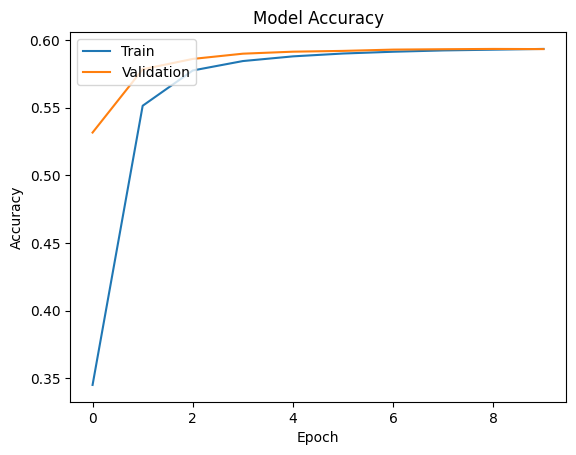

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from numpy import percentile


def load_data(file_path):
    sentences = []
    sentence = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                word, tag = line.split('\t')
                sentence.append((word, tag))
        if sentence:
            sentences.append(sentence)
    return sentences


train_sentences = load_data(r'/content/preprocessed_dataset_train.txt')
test_sentences = load_data(r'/content/preprocessed_dataset_test.txt')
word_counts = {}

tag_set = {'PAD'}

for sentence in train_sentences:
    for word, tag in sentence:
        word_counts[word] = word_counts.get(word, 0) + 1
        tag_set.add(tag)

vocab = ['<PAD>', '<UNK>'] + [word for word, count in word_counts.items() if count >= 2]
tag_list = sorted(tag_set)

word2idx = {word: idx for idx, word in enumerate(vocab)}
tag2idx = {tag: idx for idx, tag in enumerate(tag_list)}

def encode(sentences, word2idx, tag2idx):
    X = []
    y = []
    for sentence in sentences:
        x_seq = []
        y_seq = []
        for word, tag in sentence:
            x_seq.append(word2idx.get(word, word2idx['<UNK>']))
            y_seq.append(tag2idx[tag])
        X.append(x_seq)
        y.append(y_seq)
    return X, y

X_train, y_train = encode(train_sentences, word2idx, tag2idx)
X_test, y_test = encode(test_sentences, word2idx, tag2idx)

pad_tag_idx = tag2idx['PAD']

max_len = int(percentile([len(s) for s in train_sentences], 95))

X_train = pad_sequences(X_train, maxlen=max_len, padding='post', value=word2idx['<PAD>'])
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', value=word2idx['<PAD>'])
y_train = pad_sequences(y_train, maxlen=max_len, padding='post', value=pad_tag_idx)
y_test = pad_sequences(y_test, maxlen=max_len, padding='post', value=pad_tag_idx)

num_tags = len(tag_list)
y_train = utils.to_categorical(y_train, num_classes=num_tags)
y_test = utils.to_categorical(y_test, num_classes=num_tags)


def build_model(vocab_size, num_tags, embedding_dim=128, lstm_units=256):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True))

    model.add(
        layers.LSTM(lstm_units, return_sequences=True, kernel_regularizer='l2')
    )
    model.add(layers.Dropout(0.7))

    model.add(layers.Dense(num_tags, activation='softmax'))
    return model

model = build_model(len(vocab), num_tags)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


def flatten_preds(y_true, y_pred):
    y_true_flat = np.argmax(y_true.reshape(-1, num_tags), axis=1)
    y_pred_flat = np.argmax(y_pred.reshape(-1, num_tags), axis=1)

    mask = y_true_flat != tag2idx['PAD']

    return y_true_flat[mask], y_pred_flat[mask]


y_pred = model.predict(X_test)
y_true_flat, y_pred_flat = flatten_preds(y_test, y_pred)

valid_tags = np.unique(y_true_flat)
valid_tag_names = [tag_list[idx] for idx in valid_tags]

print(classification_report(
    y_true_flat,
    y_pred_flat,
    labels=valid_tags,
    target_names=valid_tag_names
))


print("\nWeighted F1 Score:", f1_score(y_true_flat, y_pred_flat, average='weighted'))
print("Macro F1 Score:", f1_score(y_true_flat, y_pred_flat, average='macro'))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [5]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_true_flat, y_pred_flat))


Confusion Matrix:
[[ 112    0    0 ...    0    0    0]
 [   0 3161    0 ...    0    0    0]
 [   0    0 4763 ...    0    0    0]
 ...
 [   0    0    0 ...    9    0    0]
 [   0    0    0 ...    0  215    0]
 [   0    0    0 ...    0    0  386]]
